## Image classifier for the SVHN dataset


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from scipy.io import loadmat
import pandas as pd
import numpy as np

 This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

The goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [6]:
# Run to load the dataset

train = loadmat('/content/drive/MyDrive/train_32x32.mat')
test = loadmat('/content/drive/MyDrive/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extracted the training and testing images and labels separately from the train and test dictionaries.
* Selected a random sample of images and corresponding labels from the dataset, and displayed them in a figure.
* Converted the training and test images to grayscale by taking the average across all colour channels for each pixel.
* Selected a random sample of the grayscale images and corresponding labels from the dataset, and displayed them in a figure.

In [7]:
from sklearn.preprocessing import OneHotEncoder

x_train = np.transpose(train['X'],(3,0,1,2))/255
x_test =  np.transpose(test['X'],(3,0,1,2))/255

encoder = OneHotEncoder(sparse=False)

y_train = encoder.fit_transform(train['y']%10)
y_test = encoder.fit_transform(test['y']%10)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [12]:
import random
import matplotlib.pyplot as plt

def random_image(x,y):
    no_sam = x.shape[0]
    index = random.sample(range(0,no_sam+1),15)
    fig , axis = plt.subplots(nrows = 3,ncols = 4, figsize =(8,8))

    for i, ax in zip(index,axis.flatten()):
        if(x[i].shape==(32,32,3)):
            ax.imshow(x[i])
        else:
            ax.imshow(x[i,...,0],cmap='gray')
        ax.set_xlabel("label:"+ str(np.argmax(y[i])))

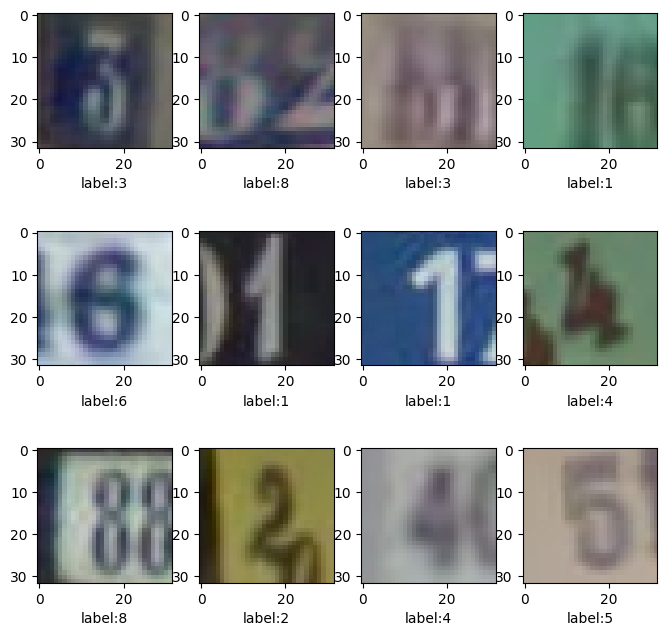

In [13]:
random_image(x_train,y_train)

In [14]:
def reshape_img(img):
    return np.dot(img,[0.2989,0.5870,0.1140])[...,np.newaxis]
x_train_gray=reshape_img(x_train).astype(np.float32)
x_test_gray=reshape_img(x_test).astype(np.float32)

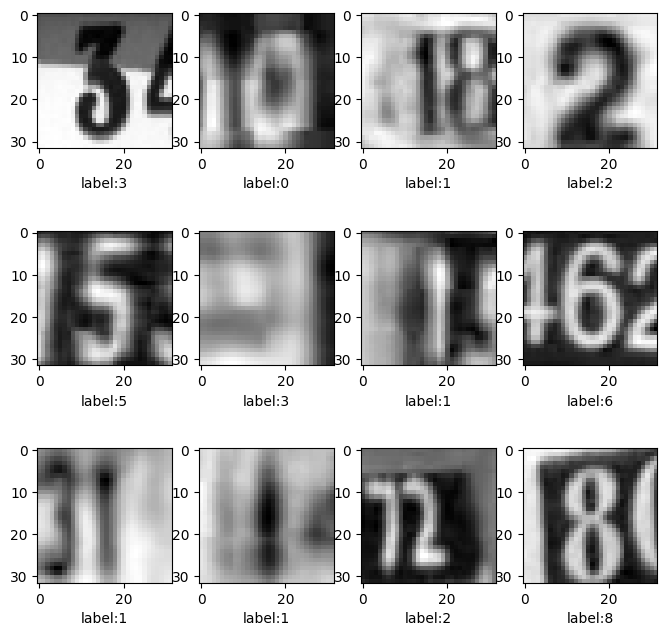

In [15]:
random_image(x_train_gray,y_train)


## 2. MLP neural network classifier
* Built an MLP classifier model using the Sequential API. The model uses only Flatten and Dense layers, with the final layer having a 10-way softmax output.
* The model summary is printed (using the summary() method)
* Compileed and trained the model, making use of both training and validation sets during the training run.
* The model tracks accuracy metric, and uses two callbacks during training, one of which is ModelCheckpoint callback.
* Aim to achieve a final categorical cross entropy training loss of less than 1.0.
* Ploted the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Computed and displayed the loss and accuracy of the trained model on the test set.

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

In [17]:
def mlp_model(input_shape):
    return Sequential([
        Flatten(name='flatten_1', input_shape = input_shape),
        Dense(128,activation = 'relu'),
        Dense(128,activation = 'relu'),
        Dense(128,activation = 'relu'),
        Dense(128,activation = 'relu'),
        Dense(64,activation = 'relu'),
        Dense(10,activation = 'softmax')
        ])
def test_result(model):
    test_loss,test_acc = model.evaluate(x_test_gray,y_test,verbose=False)
    print(f"Test Accuracy: {test_acc}")
    print(f"Test Loss: {test_loss}")

def plot_model(history):
    fig, axis = plt.subplots(nrows = 2,ncols=1,figsize=(10,10))
    axis[0].plot(history['val_loss'],label='Validation loss',color = 'green')
    axis[0].plot(history['loss'],label='training loss',color = 'red')
    axis[0].set_ylabel('val_loss')
    axis[0].set_xlabel('epoch')
    axis[0].legend()
    axis[1].plot(history['val_accuracy'],label='Validation accuracy',color = 'green')
    axis[1].plot(history['accuracy'],label='training accuracy',color = 'red')
    axis[1].set_ylabel('val_accuracy')
    axis[1].set_xlabel('epoch')
    axis[1].legend()


In [18]:
shape= x_train_gray[0].shape
mmodel = mlp_model(shape)
mmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 10)                6

In [19]:
def callback(model_type):
    early_stop = EarlyStopping(monitor='loss',patience = 10, verbose = 1)
    plateau = ReduceLROnPlateau(monitor = 'loss',patience = 10, factor=0.2)
    path = 'model-'+model_type+'/checkpoint-epoch: {epoch:02d}'
    check_path = ModelCheckpoint(filepath = path,monitor = 'val_accuracy',save_weights_only=True,save_best_only =True,verbose = 1)
    return early_stop,plateau,check_path

In [20]:
mmodel.compile(optimizer='sgd',loss='categorical_crossentropy',metrics = ['accuracy'])

In [21]:
early_stop,plateau,check_path = callback('mlp')
history = mmodel.fit(x_train_gray,y_train,epochs=30,validation_split=0.2,callbacks = [early_stop,plateau,check_path])

Epoch 1/30
1829/1832 [============================>.] - ETA: 0s - loss: 2.2108 - accuracy: 0.1948
Epoch 1: val_accuracy improved from -inf to 0.25519, saving model to model-mlp/checkpoint-epoch: 01
1832/1832 [==============================] - 8s 4ms/step - loss: 2.2107 - accuracy: 0.1950 - val_loss: 2.1615 - val_accuracy: 0.2552 - lr: 0.0100
Epoch 2/30
1823/1832 [============================>.] - ETA: 0s - loss: 1.9108 - accuracy: 0.3323
Epoch 2: val_accuracy improved from 0.25519 to 0.41796, saving model to model-mlp/checkpoint-epoch: 02
1832/1832 [==============================] - 7s 4ms/step - loss: 1.9098 - accuracy: 0.3327 - val_loss: 1.6891 - val_accuracy: 0.4180 - lr: 0.0100
Epoch 3/30
1829/1832 [============================>.] - ETA: 0s - loss: 1.5548 - accuracy: 0.4710
Epoch 3: val_accuracy improved from 0.41796 to 0.50396, saving model to model-mlp/checkpoint-epoch: 03
1832/1832 [==============================] - 6s 3ms/step - loss: 1.5546 - accuracy: 0.4711 - val_loss: 1.464

In [22]:
test_result(mmodel)

Test Accuracy: 0.7700522541999817
Test Loss: 0.7720182538032532


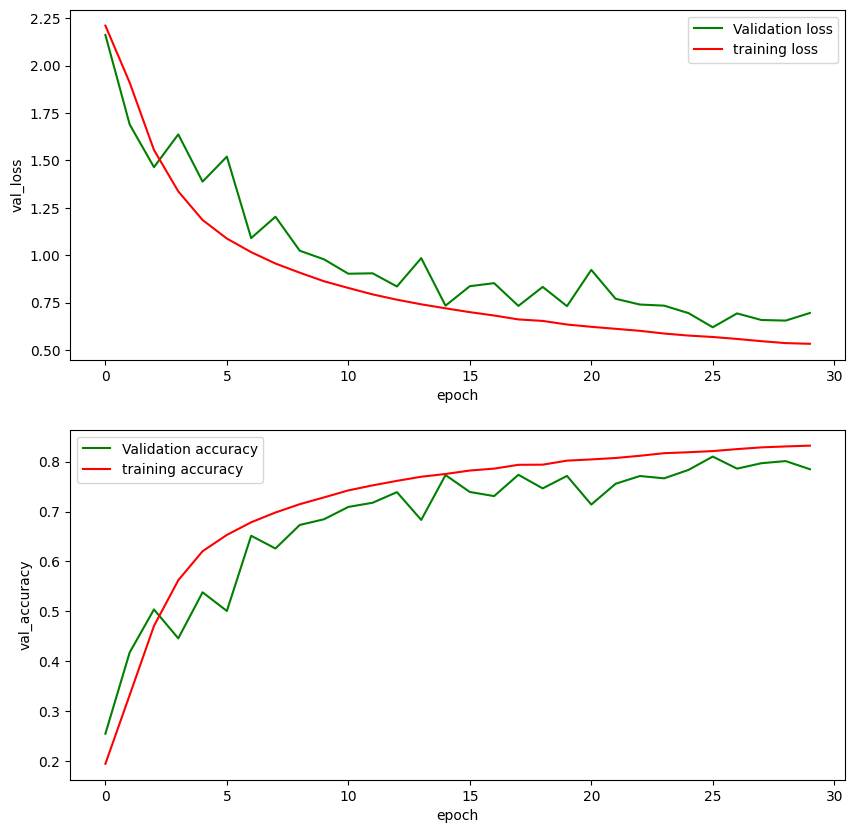

In [23]:
plot_model(history.history)

## 3. CNN neural network classifier
* Built a CNN classifier model using the Sequential API.The model uses the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer have a 10-way softmax output.
* The CNN model uses fewer trainable parameters than the MLP model.
* Compiled and trained the model, making use of both training and validation sets during the training run.
* The model tracks accuracy metric, and uses two callbacks during training, one of which is ModelCheckpoint callback.
* Aim is to beat the MLP model performance with fewer parameters!
* Ploted the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Computed and displayed the loss and accuracy of the trained model on the test set.

In [24]:
from tensorflow.keras.layers import Conv2D,MaxPool2D, BatchNormalization, Dropout

In [25]:
def cnn_model(input_shape, prob):
    return Sequential([
        Conv2D(32,kernel_size =3, input_shape = input_shape,activation = 'relu'),
        Conv2D(16,kernel_size = 3, activation = 'relu'),
        MaxPool2D(pool_size = 2),
        Flatten(),
        Dense(32,activation = 'relu'),
        Dropout(prob),
        Dense(32,activation = 'relu'),
        BatchNormalization(),
        Dense(10,activation = 'softmax')

    ])
shape = x_train_gray[0].shape
model = cnn_model(shape,0.3)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        4624      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense_6 (Dense)             (None, 32)                100384    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                      

In [26]:
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [27]:
early_stop,plateau,check_path = callback('cnn')
cnn_history = model.fit(x_train_gray,y_train,epochs = 20,callbacks = [early_stop,plateau,check_path],validation_split = 0.15)

Epoch 1/20
1945/1946 [============================>.] - ETA: 0s - loss: 1.4580 - accuracy: 0.4969
Epoch 1: val_accuracy improved from -inf to 0.75394, saving model to model-cnn/checkpoint-epoch: 01
1946/1946 [==============================] - 94s 47ms/step - loss: 1.4577 - accuracy: 0.4970 - val_loss: 0.7899 - val_accuracy: 0.7539 - lr: 0.0010
Epoch 2/20
1946/1946 [==============================] - ETA: 0s - loss: 0.8914 - accuracy: 0.7115
Epoch 2: val_accuracy improved from 0.75394 to 0.81900, saving model to model-cnn/checkpoint-epoch: 02
1946/1946 [==============================] - 90s 46ms/step - loss: 0.8914 - accuracy: 0.7115 - val_loss: 0.6087 - val_accuracy: 0.8190 - lr: 0.0010
Epoch 3/20
1945/1946 [============================>.] - ETA: 0s - loss: 0.7770 - accuracy: 0.7512
Epoch 3: val_accuracy improved from 0.81900 to 0.82027, saving model to model-cnn/checkpoint-epoch: 03
1946/1946 [==============================] - 92s 47ms/step - loss: 0.7770 - accuracy: 0.7513 - val_loss:

In [28]:
test_result(model)

Test Accuracy: 0.8493008613586426
Test Loss: 0.514320433139801


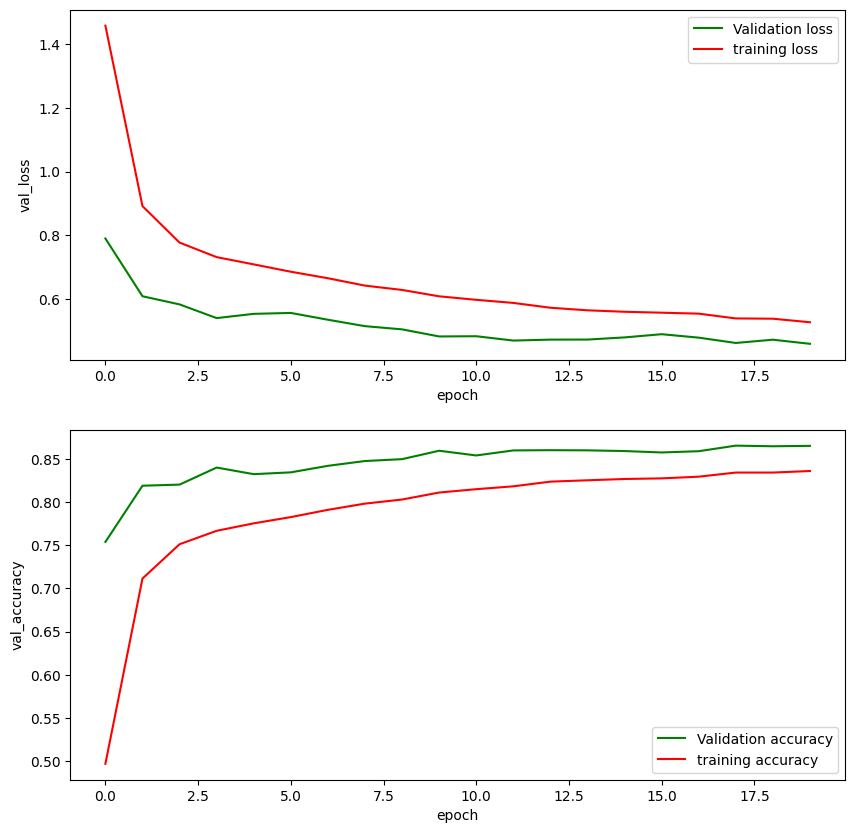

In [29]:
plot_model(cnn_history.history)

## 4. Get model predictions
* Loading the best weights for the MLP and CNN models that are saved during the training run.
* Randomly selecting 5 images and corresponding labels from the test set and displaying the images with their labels.
* Alongside the image and label, showing each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [30]:
def get_best_mlp(model):
    check_path = tf.train.latest_checkpoint('model-mlp')
    model.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
    model.load_weights(check_path)
    return model
def get_best_cnn(model):
    check_path = tf.train.latest_checkpoint('model-cnn')
    model.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
    model.load_weights(check_path)
    return model


In [31]:
mlp=get_best_mlp(mlp_model(shape))
cnn=get_best_cnn(cnn_model(x_train_gray[0].shape,0.3))

In [32]:
print("Result of MLP model:")
test_result(mlp)
print("\nResult of CNN model:")
test_result(cnn)

Result of MLP model:
Test Accuracy: 0.784649670124054
Test Loss: 0.7200733423233032

Result of CNN model:
Test Accuracy: 0.8440765142440796
Test Loss: 0.5282773375511169


In [33]:
def random_img(model):
    no_samples = x_test.shape[0]
    index=random.sample(range(1,no_samples+1),10)

    fig,axis = plt.subplots(1,5,figsize=(10,10))

    for i,ax in zip(index,axis.flatten()):
        ax.imshow(x_test[i])
        prediction = model.predict(x_test_gray[i][np.newaxis,...])
        ax.set_xlabel('prediction'+str(np.argmax(prediction)))

1/1 [==============================] - 0s 100ms/step


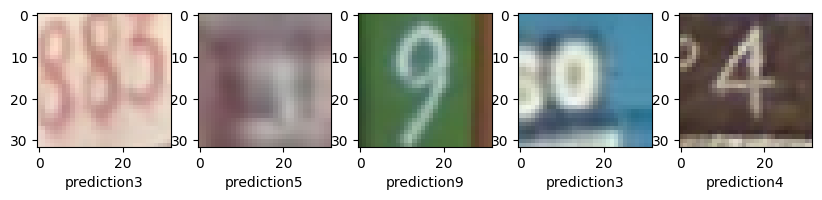

In [34]:
random_img(mlp)

1/1 [==============================] - 0s 29ms/step


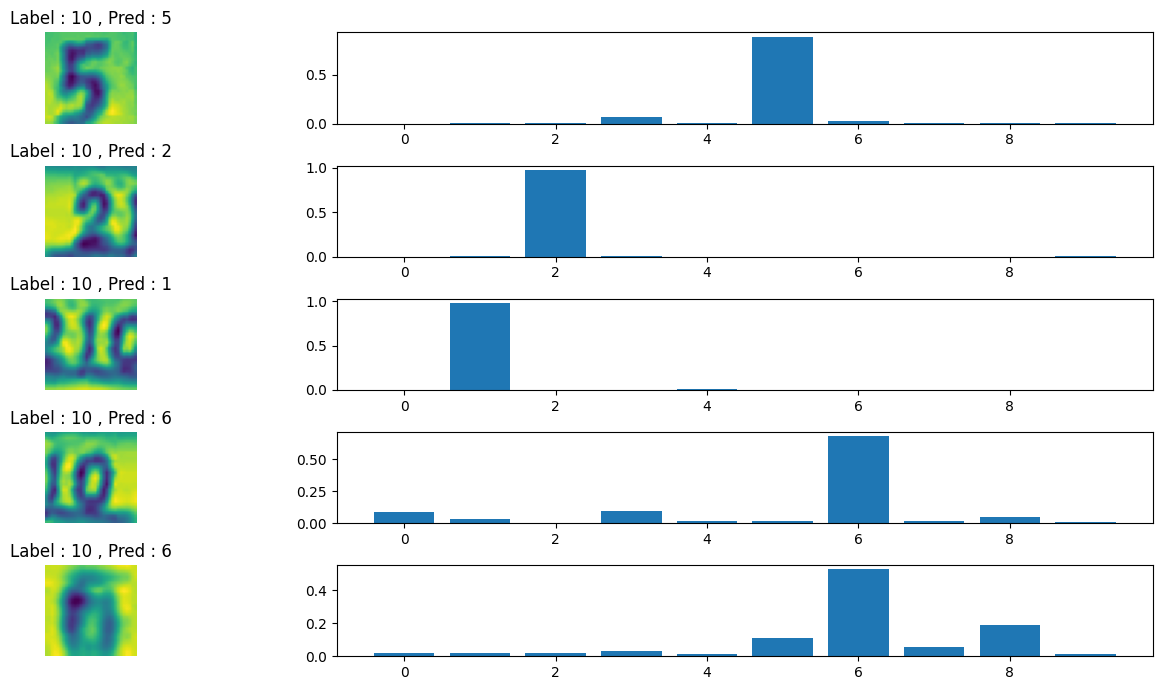

In [35]:
def image_gen(indices,tset,tlabel,model):
    fig , axlist = plt.subplots(ncols = 2, nrows = 5,figsize = (15,7))

    for ind  in range(0,len(indices)*2-1,2):
        pind = int(ind/2)
        im = tset[pind]
        distrib = model.predict(im[np.newaxis,...])
        distrib = np.reshape(distrib,(10,))
        pred = np.argmax(distrib)
        if(pred == 0):  pred = 10
        label = tlabel[pind]
        if(label.all() == 0) : label = 10
        axlist.ravel()[ind].set_axis_off()
        axlist.ravel()[ind].set_title('Label : {} , Pred : {}'.format(label, pred))
        axlist.ravel()[ind].imshow(tset[pind,:,:,0])
        axlist.ravel()[ind + 1].bar(np.arange(0,10) , height=distrib)

    fig.tight_layout()

indices = np.random.randint(1,x_test_gray.shape[0],(5,))
image_gen(indices,x_test_gray,y_test,cnn)

1/1 [==============================] - 0s 32ms/step


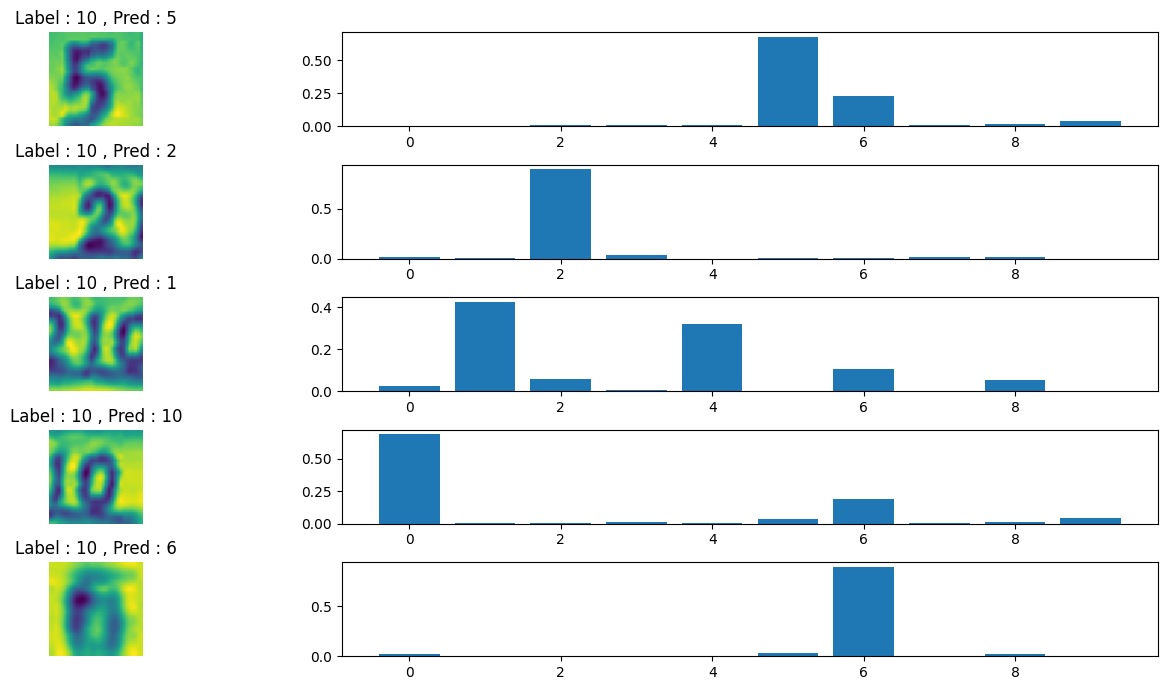

In [36]:
image_gen(indices,x_test_gray,y_test,mlp)